In [1]:
# TODO: 1. Use Train, Test, Validation split and change training/testing process
# TODO: 2. Add cross-validation (create function display_scores), confidence (create function display_confidence)
# TODO: 3. Add logs for RandomizedSearchCV results (print each iteration) create function show_cs_results

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy import stats

In [3]:
def display_scores(test_model, features, target):
    scores = cross_val_score(test_model, # model
                         features, # features
                         target, # target variable
                         scoring='neg_mean_squared_error', # scoring metric
                         cv=10) # number of folds for cross-validation
    tree_rmse_scores = np.sqrt(-scores)
    print("Scores:", tree_rmse_scores)
    print("Mean:", tree_rmse_scores.mean())
    print("Standard deviation:", tree_rmse_scores.std())

In [4]:
def display_confidence(_y_predicted, _y_test, confidence=0.95):
    squared_errors = (_y_predicted - _y_test) ** 2
    result = np.sqrt(stats.t.interval(
        confidence,
        len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors)
    ))
    print("Confidence interval for the final RMSE:", result)  # print the

In [5]:
def calculate_error(pipeline, _y_test, _y_pred):
        # Get the StandardScaler fitted on all numerical columns
        price_scaler = pipeline.named_transformers_['num'].named_steps['std_scaler']
        # Get index of 'price' in num_attribs
        price_idx = pipeline.transformers_[0][2].index('price')
        mean = price_scaler.mean_[price_idx]
        scale = price_scaler.scale_[price_idx]
        # Inverse transform only the price column
        y_test_orig = _y_test * scale + mean
        y_pred_orig = _y_pred * scale + mean
        rmse_dollars = root_mean_squared_error(y_test_orig, y_pred_orig)
        mse_dollars = mean_squared_error(y_test_orig, y_pred_orig)
        print(f'RMSE (in dollars): {rmse_dollars:.2f}')
        print(f'MSE (in dollars): {mse_dollars:.2f}')

In [6]:
# Load data
df = pd.read_csv('../../dataset/car_price_prediction.zip')

In [7]:
# Drop columns ID and Models
df.drop(columns=['ID', 'Model'], inplace=True)

In [8]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [9]:
# Rename columns to snake_case
df.rename({'Levy': 'Export Tax', 'Drive wheels': 'Axe'}, axis=1, inplace=True)
df.columns = list(map(lambda x: x.strip().replace(' ', '_').replace('.', '').lower(), df.columns))

In [10]:
# Feature Engineering (extract year from prod_year, calculate age of the car, calculate km_per_year, is_turbo, etc.)
df.export_tax = df.export_tax.replace('-', np.nan)
df.mileage = df.mileage.replace(0, np.nan)
df[['engine_volume', 'is_turbo']] = df.engine_volume.str.split(' ', expand=True)
df.engine_volume = df.engine_volume.astype(float)
df.is_turbo = df.is_turbo.map({'Turbo': True, None: False})
df.mileage = df.mileage.str.replace(' km', '').str.replace(' km', '').str.replace(' ', '').astype(int)
current_year = pd.to_datetime('today').year
df['old'] = df['prod_year'].apply(lambda x: current_year - x)
df.drop(columns=['prod_year'], inplace=True)
# df['km_per_year'] = np.where((df['old'] == 0) | (df['mileage'] == 0), df['mileage'], df['mileage'] / df['old'])
df['km_per_year'] = df['mileage'] / df['old']
df['doors'] = df['doors'].map({'02-Mar': 2, '04-May': 4, '>5': 5})

In [11]:
# let's create a correlation matrix to see how features relate to the target variable
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[num_columns].corr()
correlation_matrix['price'].sort_values(ascending=False)

price            1.000000
engine_volume    0.013849
cylinders        0.010535
km_per_year     -0.001861
mileage         -0.002009
airbags         -0.010894
old             -0.014761
doors           -0.032593
Name: price, dtype: float64

In [12]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())]
)

In [13]:
num_attribs = ['price', 'export_tax', 'engine_volume', 'mileage', 'cylinders', 'doors', 'airbags', 'old', 'km_per_year']
one_hot_attribs = ['leather_interior', 'fuel_type', 'axe', 'wheel', 'is_turbo']
label_attribs = ['manufacturer', 'gear_box_type', 'color', 'category']

full_pipeline = ColumnTransformer([
    ('num',num_pipeline, num_attribs),
    ('one_hot',OneHotEncoder(), one_hot_attribs),
    ('label', OrdinalEncoder(), label_attribs)
])

prepared_data = full_pipeline.fit_transform(df)

prepared_df = pd.DataFrame(prepared_data, columns=num_attribs + list(full_pipeline.named_transformers_['one_hot'].get_feature_names_out(one_hot_attribs)) + label_attribs)

In [14]:
# let's create a correlation matrix to see how features relate to the target variable
correlation_matrix = prepared_df.corr()
correlation_matrix['price'].sort_values(ascending=False)

price                       1.000000
fuel_type_Diesel            0.034154
wheel_Left wheel            0.016942
is_turbo_True               0.013998
engine_volume               0.013849
gear_box_type               0.011265
cylinders                   0.010535
axe_4x4                     0.006459
leather_interior_Yes        0.005912
export_tax                  0.005803
fuel_type_Plug-in Hybrid    0.001183
fuel_type_Hydrogen          0.000004
manufacturer               -0.001670
km_per_year                -0.001861
mileage                    -0.002009
axe_Rear                   -0.002844
axe_Front                  -0.003305
leather_interior_No        -0.005912
fuel_type_LPG              -0.007189
fuel_type_CNG              -0.009997
airbags                    -0.010894
color                      -0.012124
fuel_type_Petrol           -0.012393
fuel_type_Hybrid           -0.012497
is_turbo_False             -0.013998
old                        -0.014761
wheel_Right-hand drive     -0.016942
c

In [15]:
# lets select only features that have correlation with price > 0.1 or < -0.1
def select_features_with_correlation(matrix, target='price', threshold=0.01):
    correlation = matrix[target].sort_values(ascending=False)
    return correlation[abs(correlation) > threshold].index.tolist()

In [16]:
high_corr_features = select_features_with_correlation(correlation_matrix, threshold=0.005)
prepared_df = prepared_df[high_corr_features]

In [17]:
def remove_outliers(_df, _column):
    Q1 = _df[_column].quantile(0.25)
    Q3 = _df[_column].quantile(0.75)
    IQR = Q3 - Q1
    _df[column] = _df[_column].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)
    return _df[_column]

In [18]:
for column in prepared_df.columns.tolist():
    prepared_df[column] = remove_outliers(prepared_df, column)

In [19]:
# Bin the scaled price into categories for stratification
bins = 10
prepared_df['price_cat'] = pd.cut(
    prepared_df['price'],
    bins=bins,  # Adjust bins as needed for your data distribution
    labels=range(bins)
)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(prepared_df, prepared_df['price_cat']):
    strat_train_set = prepared_df.loc[train_index].drop('price_cat', axis=1)
    strat_test_set = prepared_df.loc[test_index].drop('price_cat', axis=1)

X_train, X_test, y_train, y_test = strat_train_set.drop('price', axis=1), strat_test_set.drop('price', axis=1), strat_train_set['price'], strat_test_set['price']

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [21]:
display_scores(model, X_train, y_train)

Scores: [0.05192664 0.05365188 0.0517646  0.05292748 0.05177954 0.05249188
 0.05266777 0.05331468 0.05203775 0.05012879]
Mean: 0.0522691000780869
Standard deviation: 0.0009430425480081242


In [22]:
calculate_error(full_pipeline, y_test, y_pred) # Current RSME $ 10921.86

RMSE (in dollars): 10983.22
MSE (in dollars): 120631134.41


In [23]:
display_confidence(y_pred, y_test)

Confidence interval for the final RMSE: [0.05079444 0.05340325]


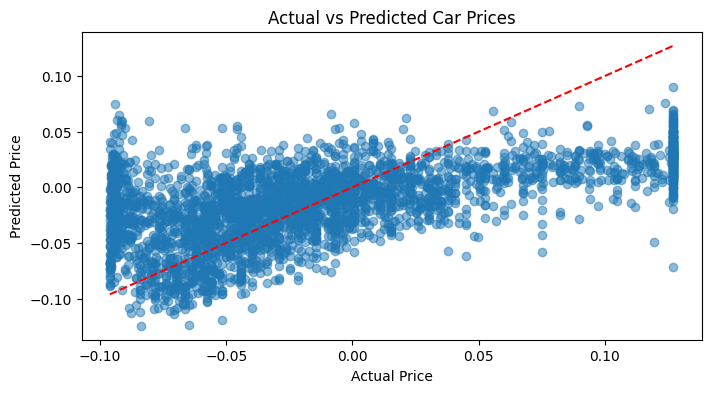

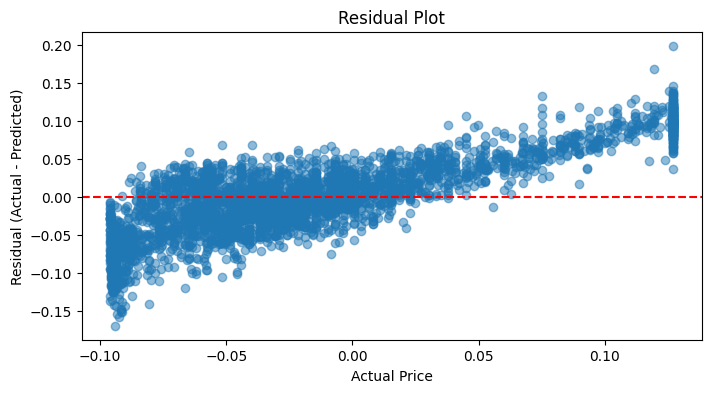

In [24]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

# Residual plot: Error vs Actual
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

In [25]:
# Let's try use model that less sensitive to outliers (e.g. Random Forest)
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
y_rf_pred = dt_model.predict(X_test)

In [26]:
display_scores(dt_model, X_train, y_train)

Scores: [0.048144   0.04521961 0.04430298 0.04508848 0.0448194  0.04663252
 0.0447063  0.04629822 0.04624962 0.04716614]
Mean: 0.045862726007988644
Standard deviation: 0.001170757299317054


In [27]:
display_confidence(y_rf_pred, y_test)

Confidence interval for the final RMSE: [0.04322468 0.0475821 ]


In [28]:
calculate_error(full_pipeline, y_test, y_rf_pred)

RMSE (in dollars): 9579.73
MSE (in dollars): 91771221.34


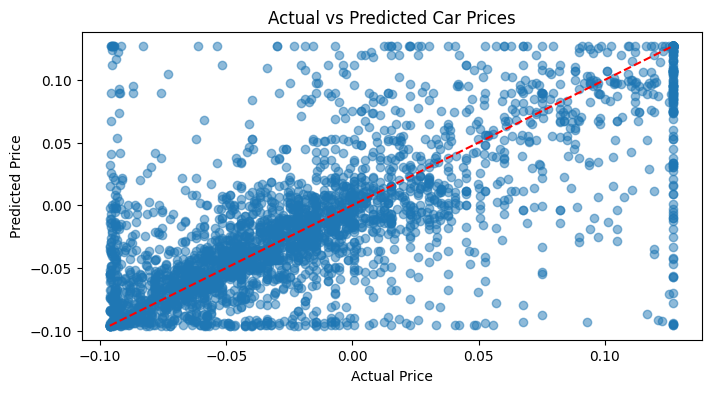

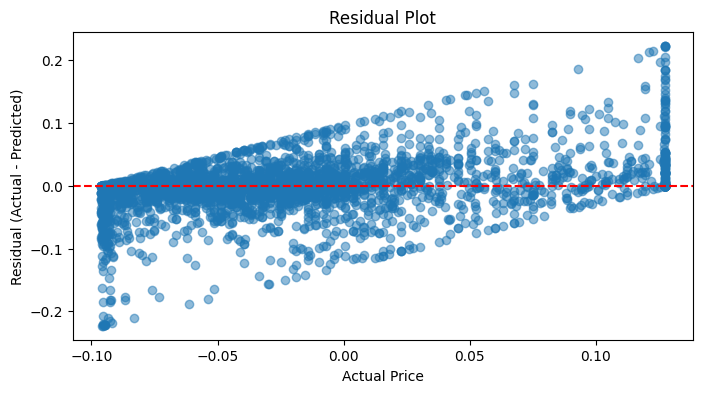

In [29]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_rf_pred, alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

# Residual plot: Error vs Actual
residuals = y_test - y_rf_pred
plt.figure(figsize=(8, 4))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

In [30]:
# most important features
feature_importances = dt_model.feature_importances_
attributes = X_train.columns.tolist()
sorted(zip(feature_importances, attributes), reverse=True)  # sort the feature importances and attributes

[(0.2607255595191907, 'old'),
 (0.17752680818794644, 'airbags'),
 (0.15926973072528464, 'engine_volume'),
 (0.10660476266010602, 'export_tax'),
 (0.09578457113122472, 'gear_box_type'),
 (0.07436071605957484, 'category'),
 (0.06520631810572765, 'color'),
 (0.024907802691310942, 'fuel_type_Petrol'),
 (0.0233947699029741, 'leather_interior_Yes'),
 (0.012218961016659955, 'leather_interior_No'),
 (0.0, 'wheel_Right-hand drive'),
 (0.0, 'wheel_Left wheel'),
 (0.0, 'is_turbo_True'),
 (0.0, 'is_turbo_False'),
 (0.0, 'fuel_type_LPG'),
 (0.0, 'fuel_type_Hybrid'),
 (0.0, 'fuel_type_Diesel'),
 (0.0, 'fuel_type_CNG'),
 (0.0, 'doors'),
 (0.0, 'cylinders'),
 (0.0, 'axe_4x4')]

In [31]:
dt_model_imp = DecisionTreeRegressor()
dt_model_imp.fit(X_train, y_train)
y_imp_pred = dt_model_imp.predict(X_test)

In [32]:
calculate_error(full_pipeline, y_test, y_imp_pred)  # Current RSME $ 9644

RMSE (in dollars): 9644.53
MSE (in dollars): 93016991.06


In [33]:
display_scores(dt_model, X_train, y_train) # TODO: need revert scaling inside function

Scores: [0.04796623 0.04550893 0.04434833 0.04603894 0.04489439 0.0470005
 0.04467187 0.04593686 0.04612865 0.04798944]
Mean: 0.046048414193165674
Standard deviation: 0.0012156898749193124


In [34]:
display_confidence(y_rf_pred, y_test) # TODO: need revert scaling inside function

Confidence interval for the final RMSE: [0.04322468 0.0475821 ]


In [ ]:
# Let's try to use RandomizedSearchCV to find the best hyperparameters for DecisionTreeRegressor

param_distributions = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = DecisionTreeRegressor(random_state=42)

cv = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    cv=5,  # Number of folds for cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

cv.fit(X_train, y_train)

In [ ]:
cv_y_pred = cv.predict(X_test)

In [ ]:
best_params = cv.best_params_
best_model = cv.best_estimator_
all_results = cv.cv_results_

In [ ]:
calculate_error(full_pipeline, y_test, cv_y_pred)

In [ ]:
display_scores(best_model, X_train, y_train)

In [ ]:
display_confidence(best_model, y_test, cv_y_pred)

In [ ]:
# we can check the best hyperparameters and the best model
for mean_score, params in zip(all_results['mean_test_score'], all_results['params']):
    print(np.sqrt(-mean_score), params)  # print the RMSE and the hyperparameters for each combination